<a href="https://www.kaggle.com/code/fall2fire/cat-disease-classification?scriptVersionId=277294724" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries Required 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.utils.class_weight import compute_class_weight

2025-11-13 14:30:56.038449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763044256.221993      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763044256.278492      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(640, 640, 3)


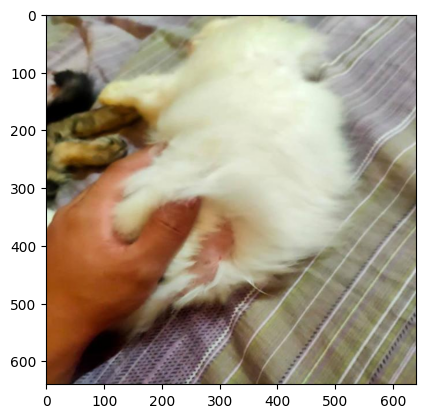

In [2]:
# Providing path to dataset
base_dir ='/kaggle/input/cat-skin-disease/CAT SKIN DISEASE'
image_path='/kaggle/input/cat-skin-disease/CAT SKIN DISEASE/Ringworm/135195862_10222884899858522_306512586281914012_n_jpg.rf.cc1cebfaa035dc7858b4308b2c029735.jpg'

# Reading the image
img=mpimg.imread(image_path)
print(img.shape)

#display image
plt.imshow(img)
plt.axis()
plt.show()

# Image data Preprocessing 

In [3]:
img_size = 224
batch_size = 32

def resize_and_pad(img):
    desired_size = 224
    old_size = img.shape[:2]  # (height, width)

    # Compute ratio and new size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    img = cv2.resize(img, (new_size[1], new_size[0]))

    # Padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img / 255.0  # Normalize [0, 1]

data_gen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    rotation_range=25,
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)



train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear',
    shuffle=True
)

valid_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Class sample counts:", np.bincount(train_gen.classes))

Found 415 images belonging to 4 classes.
Found 135 images belonging to 4 classes.
Class indices: {'Flea_Allergy': 0, 'Health': 1, 'Ringworm': 2, 'Scabies': 3}
Class sample counts: [107  84 111 113]


## Providing Class Weights as we have imbalance image classes

Class Weights: {0: 0.969626168224299, 1: 1.2351190476190477, 2: 0.9346846846846847, 3: 0.918141592920354}


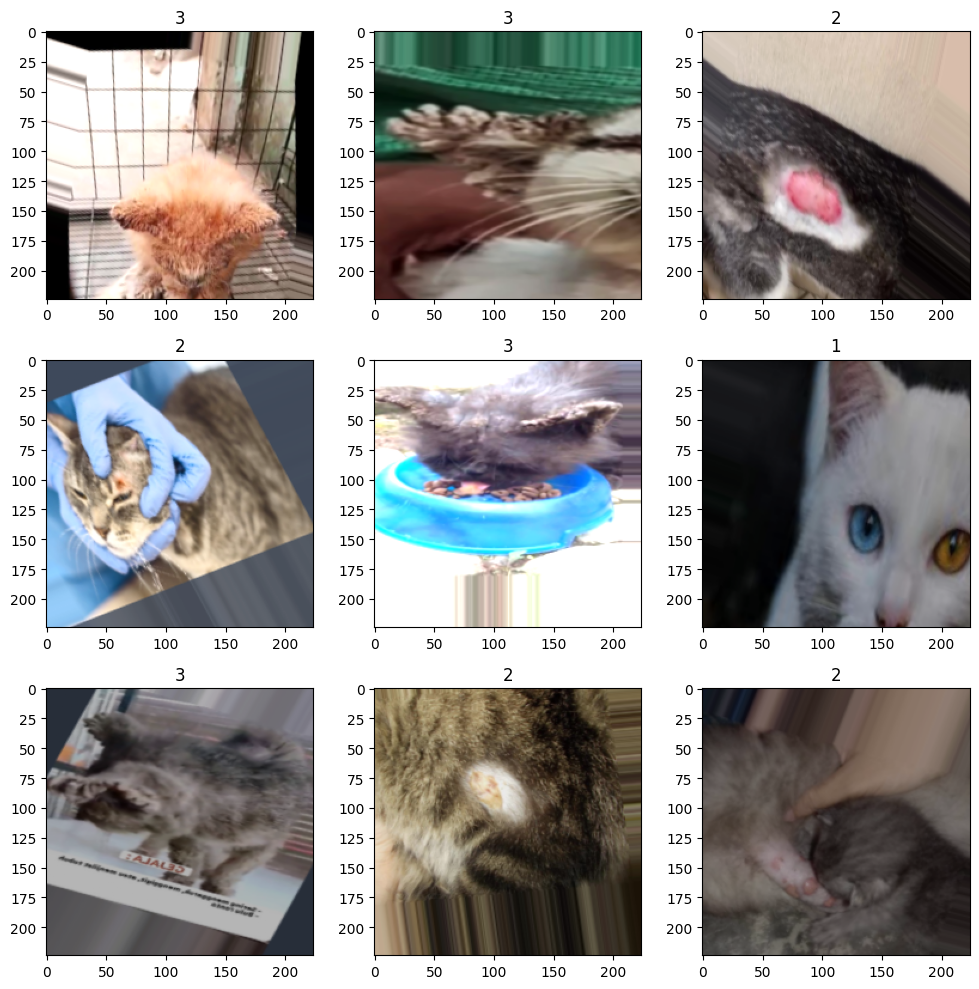

In [4]:
#  Compute Class Weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


# Preview Images 
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis()
plt.tight_layout()
plt.show()

# Model ---->ResNet50V2

In [5]:
from tensorflow.keras import layers , models
from tensorflow.keras.applications import ResNet50V2
base_model = ResNet50V2(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.summary()

I0000 00:00:1763044271.473146      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# Training 

In [6]:
# Compile the Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#Training the Model
history=model.fit(
    train_gen,
    epochs=25,
    validation_data=valid_gen,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1763044285.552017      78 service.cc:148] XLA service 0x7e5444001610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763044285.552808      78 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763044286.996681      78 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/13 ━━━━━━━━━━━━━━━━━━━━ 3:13 16s/step - accuracy: 0.2500 - loss: 2.3674

I0000 00:00:1763044291.811816      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4505 - loss: 1.6068 - val_accuracy: 0.5407 - val_loss: 1.1269
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 770ms/step - accuracy: 0.7687 - loss: 0.6184 - val_accuracy: 0.6815 - val_loss: 0.7886
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 784ms/step - accuracy: 0.8742 - loss: 0.3814 - val_accuracy: 0.7185 - val_loss: 0.7583
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 775ms/step - accuracy: 0.8713 - loss: 0.3670 - val_accuracy: 0.7111 - val_loss: 0.7918
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 775ms/step - accuracy: 0.8740 - loss: 0.3317 - val_accuracy: 0.7333 - val_loss: 0.7568
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 763ms/step - accuracy: 0.8863 - loss: 0.3050 - val_accuracy: 0.7407 - val_loss: 0.7304
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 756ms/step - accuracy: 0.9184 - loss: 0.2159 - val_accuracy: 0.7185 - val_loss: 0.8217
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 762ms/step - accuracy: 0.9142 - loss: 0.1982 - val_accuracy: 0.7481 -

## Evaluation of model

In [7]:
print("Evaluating model........")
val_loss,val_accuracy=model.evaluate(valid_gen,steps=valid_gen.samples//batch_size)
print(f"validation accuracy:{val_accuracy*100:.2f}%")

Evaluating model........
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.6625 - loss: 1.5886
validation accuracy:74.22%


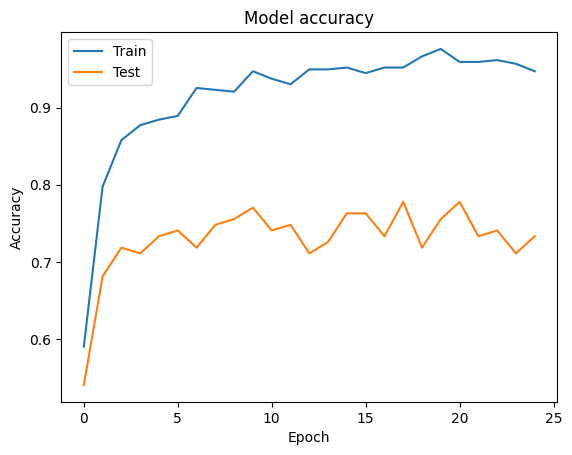

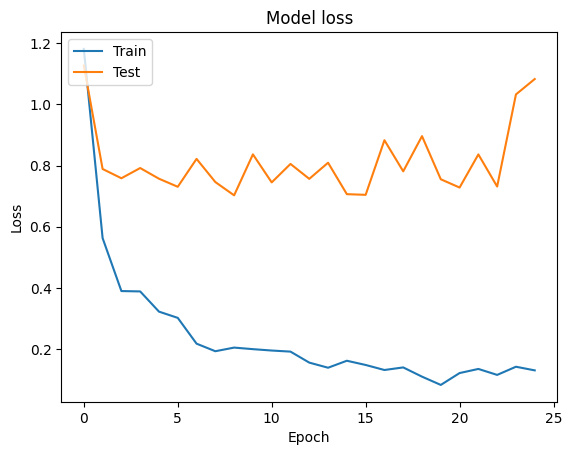

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()


# Classification Report for final evaluation

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true and predicted labels
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

# Report
print(classification_report(Y_true,Y_pred,target_names=valid_gen.class_indices.keys()))


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
              precision    recall  f1-score   support

Flea_Allergy       0.89      0.49      0.63        35
      Health       0.64      0.85      0.73        27
    Ringworm       0.54      0.78      0.64        36
     Scabies       0.89      0.68      0.77        37

    accuracy                           0.69       135
   macro avg       0.74      0.70      0.69       135
weighted avg       0.75      0.69      0.69       135



## I ve tried various pretrained CNN models like EfficientNetB7,DenseNet201,ResNet101 but out of all best  performance was provided by *ResNet50V2*
**Feel Free to collaborate and make it better.....**

# 👍